In [130]:
using Plots
using NPZ
using SCYFI
using GTF
using LinearAlgebra
using MultivariateStats
using Arblib
using Combinatorics
using Random
using ManifoldLearning
using Distances


In [2]:

function generate_bitflip_k(bitvector, k)
    M = length(bitvector)
    bitflip_k_versions = []
    mutable_bitvector = copy(bitvector)  # Create a mutable copy
    for indices in combinations(1:M, k)
        for i in indices
            mutable_bitvector[i] = !mutable_bitvector[i]
        end
        push!(bitflip_k_versions, copy(mutable_bitvector))  # Push a copy of the modified bitvector
        for i in indices  # Reset the modified bits back to original values
            mutable_bitvector[i] = !mutable_bitvector[i]
        end
    end
    return bitflip_k_versions
end


"""
ALRNN
"""
function get_latent_time_series_backwards(time_steps:: Integer, A:: Array, W:: Array, h:: Array, dz::Integer, num_relus::Integer; z_0:: Array= nothing,  D_pool::Any = [], traj=nothing, correction_T=nothing)
    if z_0 === nothing
        z = transpose(randn(1,dz))
    else
        z = z_0
    end
    trajectory = Array{Array}(undef, time_steps)
    trajectory[1] = z_0
    for t = 2:time_steps
        z,D_pool = latent_step_backwards(z, A, W, h, num_relus, D_pool)
        if z === nothing
            return trajectory[1:t-1],D_pool
        end
        #return if value out of interesting regime
        if any(abs.(z) .> 100000)
            return trajectory[1:t-1],D_pool
        end
        trajectory[t] = z
    end
    return trajectory,D_pool
end

"""
ALRNN step
"""
function latent_step_backwards(z:: Array, A:: Array, W:: Array, h::Array,num_relus::Integer, D_pool::Any)
    dims = size(A)[1]
    D = Diagonal(vcat(ones(dims-num_relus),z[end-(num_relus-1):end].>0))
    z_candidate =BigFloat.(Arblib.inv(A+W*D)*(z-h))
    z_forward=latent_step_old(z_candidate, A, W, h,num_relus)
    if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
        D_int= parse(Int, join(diag(Bool.(D)) .|> (x -> x ? "1" : "0")), base=2)
        if D_int ∈ D_pool
            return z_candidate,D_pool
        else
            push!(D_pool,D_int)
            return z_candidate,D_pool
        end
    else
        D = Diagonal(vcat(ones(dims-num_relus),z_candidate[end-(num_relus-1):end].>0))
        z_candidate =BigFloat.(Arblib.inv(A+W*D)*(z-h))
        z_forward=latent_step_old(z_candidate, A, W, h,num_relus)
        if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
            D_int= parse(Int, join(diag(Bool.(D)) .|> (x -> x ? "1" : "0")), base=2)
            if D_int ∈ D_pool
                return z_candidate,D_pool
            else
                push!(D_pool,D_int)
                return z_candidate,D_pool
            end	
        else
            #println("Test previously visited regions")
            for D_int in D_pool
                D = Diagonal(convert(Array{Bool},collect(bitstring(D_int)[length(bitstring(D_int))-dims+1:end]).=='1'))
                z_candidate =BigFloat.(Arblib.inv(A+W*D)*(z-h))
                z_forward=latent_step_old(z_candidate, A, W, h,num_relus)
                if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
                    return z_candidate,D_pool
                end
            end
            #println("entered combinatorics mode")
            D = Bool.(Diagonal(vcat(ones(dims-num_relus),z[end-(num_relus-1):end].>0)))
            for k=1:num_relus
               # println("Testing all flips of order $k")
                D_versions=generate_bitflip_k(diag(D)[end-(num_relus-1):end], k)
                for Ds in D_versions#0:0.1:50
                    D_=Diagonal(vcat(ones(dims-num_relus),Ds))
                    try
                        z_candidate =BigFloat.(Arblib.inv(A+W*D_)*(z-h))
                        z_forward=latent_step_old(z_candidate, A, W, h,num_relus)
                    catch ex 
                        if isa(ex,SingularException)
                            continue
                        else 
                            return error(ex)
                        end
                    end

                    if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
                        D_int= parse(Int, join(Bool.(diag(D_)) .|> (x -> x ? "1" : "0")), base=2)
                        if D_int ∈ D_pool
                            return z_candidate,D_pool
                        else
                            push!(D_pool,D_int)
                            return z_candidate,D_pool
                        end                        
                    end
                end
            end
            println(z)
            println(round.(Float64.(z),sigdigits=2))
            #println(z_candidate)
            println(round.(Float64.(z_forward),sigdigits=2))
            return nothing,D_pool #error("HEURISTIC FAILED YOU NEED TO FIND A DIFFERENT SOLUTION")
        end
   
    end
end

function euclidean_distance(p1, p2)
    return sqrt(sum((p1 .- p2) .^ 2))
end
"""
ALRNN step
"""
function latent_step_old(z:: Array, A:: Array, W:: Array, h::Array,num_relus)
    return A*z + W* vcat(z[1:end-num_relus,:], max.(0,z)[end-(num_relus-1):end,:]) + h
end


latent_step_old

In [521]:
data=npzread("C:/Users/Lukas.Eisenmann/Documents/PhD/Code/SCYFI//Figures/Figure4/example cell/ExampleCell/lukas_data.npy")
#model_path = "C:/Users/Lukas.Eisenmann/Documents/PhD/Code/SCYFI/Results/Example_cell_MAE_Condreg1e-5_4_noise_3/Empirical-M_ALRNN-O_Identity-T_100-clip_10.0-τ_10-M_15-relu_6-L2reg_0.3/003/checkpoints"#workes for cyscle MODEL 1200
#model_path = "C:/Users/Lukas.Eisenmann/Documents/PhD/Code/SCYFI/Results/Example_cell_Condreg1e-5_4_noise/Empirical-M_ALRNN-O_Identity-T_100-clip_10.0-τ_10-M_15-relu_6-L2reg_0.3/003/checkpoints" #model 1650 
model_path = "C:/Users/Lukas.Eisenmann/Documents/PhD/Code/SCYFI/Results/Example_cell_Condreg1e-5_4_noise/Empirical-M_ALRNN-O_Identity-T_100-clip_10.0-τ_10-M_15-relu_6-L2reg_0.3/020/checkpoints" #model 1800
m, O = load_model(model_path*"/model_"*"1800"*".bson")
traj=generate(m,O,data[10,1:end],10000000)

10000000×6 Matrix{Float64}:
 -0.284151   -0.406783   -0.090522   -0.451963   -0.361603   -0.0647047
 -0.0462769  -0.113974   -0.0583527  -0.0596016  -0.151462   -0.0121403
  0.0291909  -0.794589    0.516164   -0.0579442  -0.476734    0.170712
  0.0184657  -0.61565     0.830123   -0.0424324  -0.414519    0.398058
 -0.0569976  -0.326162    0.78454    -0.108597   -0.254834    0.426519
 -0.141142   -0.257405    0.876625   -0.203352   -0.0962876   0.472925
 -0.154526   -0.225505    1.14952    -0.219061   -0.0545017   0.648212
 -0.152497   -0.241254    1.334      -0.204629   -0.096301    0.795424
 -0.203531   -0.230443    1.22011    -0.232457   -0.103653    0.769052
 -0.310554   -0.117124    0.866856   -0.287353   -0.0256698   0.596319
  ⋮                                                           ⋮
 -0.477369   -0.391059   -0.208621   -0.393572   -0.418376    0.156328
 -0.499304   -0.412284    0.107779   -0.367156   -0.433019    0.375289
 -0.4864     -0.436042    0.560039   -0.347035   -0.43

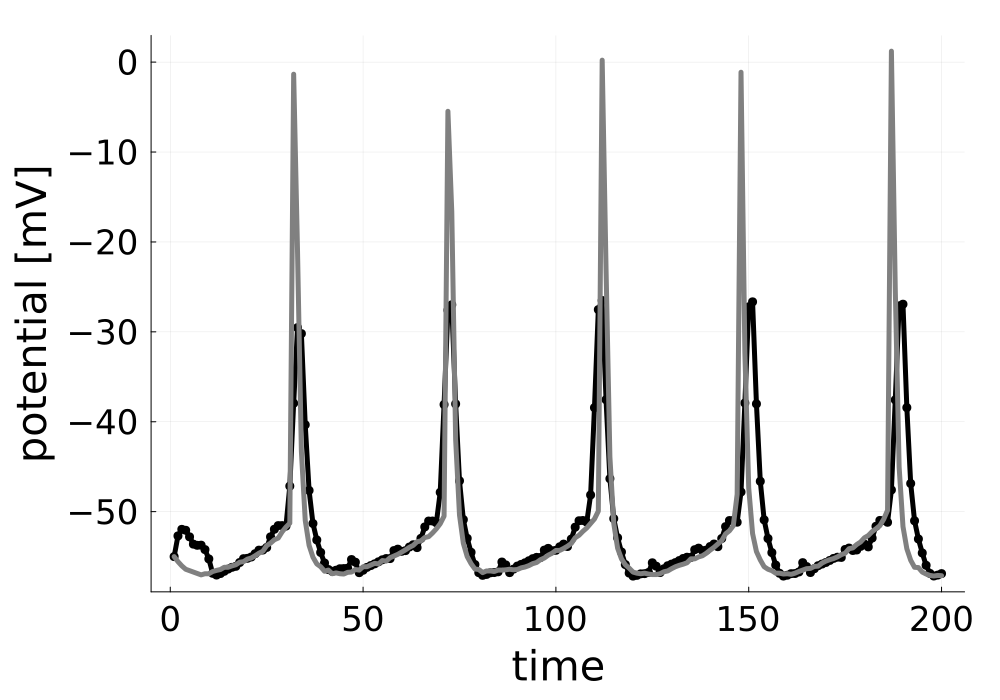

In [522]:
unique_points = unique(round.(traj[9999500:end,1],digits=3),dims=1)
println(length(unique_points))
mean = -0.05224843587548712
std = 0.00968304068272246

#smaller markersA
kl=plot([1:200],(traj[1:200,1].*std.+mean).*1000,markersize=5,label="generated",size=(1000,700),xtickfont=font(23), 
ytickfont=font(23),xguidefontsize=28,yguidefontsize=28,legendfont=font(22),linewidth=5,margin=7Plots.mm,color="black",legend=false,marker=:circle)
plot!([1:200],(data[10:209,1].*std.+mean).*1000,label="data",color="gray",linewidth=5)
xlabel!("time")
ylabel!("potential [mV]")




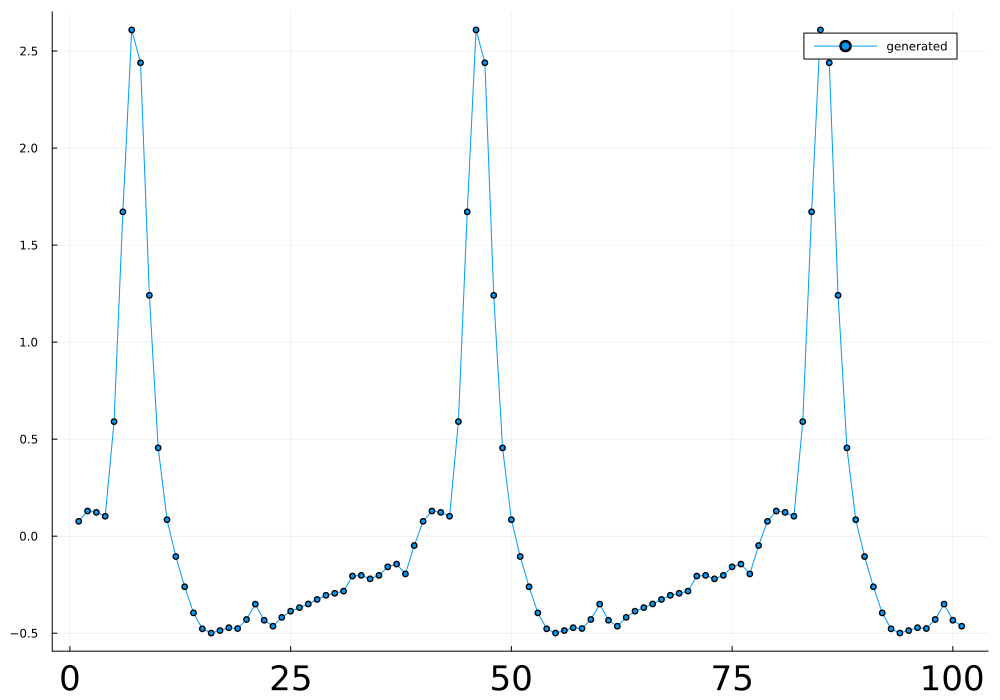

In [523]:
plot(traj[9999900:end,1],markersize=3,marker=:circle,label="generated",size=(1000,700),xtickfont=font(23))

In [524]:
A=diagm(m.A)
W=m.W
h=m.h
num_relus=m.n
dims = size(A)[1]

15

In [141]:
res=find_cycles(A,W,h,num_relus,1,outer_loop_iterations=400,inner_loop_iterations=1000,)

2-element Vector{Vector{Array}}:
 [Array[Array[Float32[-0.15908985, 0.0556464, -0.09813191, 0.00075609516, 0.25980568, -0.13518295, -0.23279218, -0.38465962, -0.0055553117, -0.097768724, 0.0019202338, -0.68687624, -0.30460292, 0.5012249, 0.5675605]], Array[Float32[-0.20173742, 0.2212763, -0.18696737, -0.036460675, 0.36662295, -0.18166083, -0.44154918, -0.5081214, 0.095310315, 0.12835763, -0.6735798, -1.362425, -0.46198386, 0.52704036, 0.46472192]], Array[Float32[-0.15737201, -0.14830919, 0.085505, -0.01361327, 0.1652656, -0.021136321, -0.048202842, -0.3535783, -0.17671005, -0.33032236, 0.011657724, 0.13348505, -0.24436446, 0.34732622, 0.5936724]]]]
 [Array[ComplexF32[0.051772013f0 - 0.5665266f0im, 0.051772013f0 + 0.5665266f0im, 0.24656758f0 - 0.31713417f0im, 0.24656758f0 + 0.31713417f0im, 0.31882286f0 + 0.0f0im, 0.3394636f0 - 0.6261883f0im, 0.3394636f0 + 0.6261883f0im, 0.40019822f0 + 0.0f0im, 0.43892926f0 + 0.0f0im, 0.44299895f0 + 0.0f0im, 0.5924174f0 + 0.0f0im, 0.8277639f0 + 0.0f0im, 

In [142]:
println(length(res[2][1]))
for i=1:length(res[2][1])
    println(all.(abs.(res[2][1][i]).<1))
    println(all(abs.(res[2][1][i]).<1))
end


In [22]:
res=find_cycles(A,W,h,num_relus,[1,39],outer_loop_iterations=500,inner_loop_iterations=500,PLRNN=SCYFI.ALRNN())


cpu version


2-element Vector{Vector{Array}}:
 [Array[Array[Float32[0.11649009, -0.16853245, -0.30049473, 0.17893712, -0.1782103, -0.2990857, -0.17946461, -0.21477531, -0.20773347, 0.3814065, 0.16345195, 0.1608581, 0.023629554, -0.19808231, 0.18446496]], Array[Float32[0.0990037, -0.6349637, -0.41393846, 0.18219459, -0.6047759, -0.31922945, 0.6957567, -0.2777895, 0.22360262, 0.46849138, 0.60551566, -2.0567253, 0.7606903, 0.05156006, 1.6066536]], Array[Float32[0.06528273, -0.59328306, -0.39654195, 0.14302559, -0.56623673, -0.30965284, 0.60439986, -0.3172676, 0.1446518, 0.40436015, 0.57547444, -1.8297485, 0.7240586, -0.02591609, 1.4690576]]], Array[Array[Float32[0.12002683, -0.43168604, -0.19840938, 0.03152939, -0.42452654, -0.1807816, 0.7271328, -0.90964913, 0.09122206, -0.5459174, 0.7824335, -1.7666405, 1.1205628, -0.52216464, 1.2835506], Float32[-0.1636774, -0.41547704, -0.18122464, -0.23820718, -0.40943816, -0.15141827, 0.76647663, -1.0113004, -0.008881636, -0.63394606, 0.8059446, -1.732283, 1.134

In [525]:
res2=find_cycles(A,W,h,num_relus,39,outer_loop_iterations=500,inner_loop_iterations=500,PLRNN=SCYFI.ALRNN())


2-element Vector{Vector{Array}}:
 [Array[Array[Float32[-0.20173742, 0.2212763, -0.18696737, -0.036460675, 0.36662295, -0.18166083, -0.44154918, -0.5081214, 0.095310315, 0.12835763, -0.6735798, -1.362425, -0.46198386, 0.52704036, 0.46472192]], Array[Float32[-0.15737201, -0.14830919, 0.085505, -0.01361327, 0.1652656, -0.021136321, -0.048202842, -0.3535783, -0.17671005, -0.33032236, 0.011657724, 0.13348505, -0.24436446, 0.34732622, 0.5936724]], Array[Float32[-0.15908985, 0.0556464, -0.09813191, 0.00075609516, 0.25980568, -0.13518295, -0.23279218, -0.38465962, -0.0055553117, -0.097768724, 0.0019202338, -0.68687624, -0.30460292, 0.5012249, 0.5675605]]], Array[], Array[], Array[], Array[], Array[], Array[], Array[], Array[], Array[]  …  Array[], Array[], Array[], Array[], Array[], Array[], Array[], Array[], Array[], Array[Array[Float32[0.12867743, -0.16110593, -0.27011067, 0.11846556, -0.31421676, -0.34151447, 0.17253523, -0.2745168, 0.35242116, -0.2406648, -1.1768849, -1.7774899, 0.25049153

In [44]:
abs.(res2[2][2][2])



15-element Vector{Float32}:
 1.8866251f-7
 2.5758777f-7
 2.5758777f-7
 2.2968297f-8
 5.2655658f-9
 5.2655658f-9
 1.88409f-8
 1.88409f-8
 6.235797f-8
 1.3118598f-7
 1.5808013f-5
 0.00011504575
 0.0012441945
 0.3798126
 0.53198576

In [13]:
using JSON
function complex_to_dict(z::Complex)
    return Dict("real" => real(z),"imag" => imag(z))
end
# Function to process arrays recursively
function process_array(arr)
    return map(arr) do x
        if x isa Array
            process_array(x)
        elseif x isa Complex
            complex_to_dict(x)
        else
            x
        end
    end
end

# Create the data structure to save
data = Dict(
    "cycles" => process_array(res2)
)

# Save to JSON file
open(model_path*"dynamical_objects_until_39.json", "w") do f
    JSON.print(f, data, 4)  # The 4 argument adds pretty printing with indentation
end

In [24]:
points = Vector[]
for i in eachindex(res2[1])
    #println(length(res2[1][i]))
    try
        for j in eachindex(res2[1][i])
           for k = 1:length(res2[1][i][j])
                #for n =1:j
                println(res2[1][i][j])
                push!(points,res2[1][i][j][k])
                #end
            end
         end
    catch
        continue
    end
end
#M = fit(PCA, transpose(mapreduce(permutedims, vcat, points)); maxoutdim=2)

Array[Float32[0.06528273, -0.59328306, -0.39654195, 0.14302559, -0.56623673, -0.30965284, 0.60439986, -0.3172676, 0.1446518, 0.40436015, 0.57547444, -1.8297485, 0.7240586, -0.02591609, 1.4690576]]
Array[Float32[0.11649009, -0.16853245, -0.30049473, 0.17893712, -0.1782103, -0.2990857, -0.17946461, -0.21477531, -0.20773347, 0.3814065, 0.16345195, 0.1608581, 0.023629554, -0.19808231, 0.18446496]]
Array[Float32[0.0990037, -0.6349637, -0.41393846, 0.18219459, -0.6047759, -0.31922945, 0.6957567, -0.2777895, 0.22360262, 0.46849138, 0.60551566, -2.0567253, 0.7606903, 0.05156006, 1.6066536]]
Array[Float32[-0.43830052, -0.33687294, 0.03675697, -0.43515134, -0.32611305, 0.014126264, 0.45149314, -1.8651218, -0.89281243, -1.5489591, 0.80031157, -0.5727631, 1.291292, -1.9850628, 0.63189244], Float32[-0.4404698, -0.32662097, 0.1382396, -0.43781567, -0.31601757, 0.08566907, 0.33500054, -2.1271434, -1.0875419, -1.9161844, 0.8697648, -0.2645476, 1.3793727, -2.3776546, 0.4209629], Float32[-0.4420939, -0.

Excessive output truncated after 524329 bytes.

Float32[-0.29366222, 0.3235104, -0.4474377, -0.28074503, 0.28602418, -0.44351837, -0.4602657, 0.51670146, 1.819373, -1.30315, -6.714819, 2.5638235, -9.111093, -2.0538497, -1.2447227], Float32[-0.2766649, 0.5404482, -0.45079023, -0.2630284, 0.46945992, -0.4436409, 0.10613541, 1.0581982, 2.1940975, -0.4210959, -6.396618, 1.7531477, -8.653385, -0.68292207, -0.43487433], Float32[-0.2620986, 0.7612815, -0.4464203, -0.24868856, 0.6591663, -0.43874565, 0.61313474, 1.4318258, 2.3329468, 0.40006012, -5.847924, 1.0029036, -7.7596173, 0.5696557, 0.3255423], Float32[-0.23447162, 0.77300245, -0.4354247, -0.2199428, 0.65911525, -0.4292551, 0.8578061, 1.5757632, 2.2861395, 1.0450369, -5.0811744, 0.5680252, -6.614505, 1.5282335, 0.9044426], Float32[-0.20927802, 0.49245954, -0.43307787, -0.19995393, 0.39537057, -0.4244679, 0.81336904, 1.5356182, 2.1785717, 1.4535887, -4.159773, 0.4965821, -5.513009, 2.1004992, 1.2261254], Float32[-0.17948844, 0.150657, -0.42620605, -0.17121708, 0.08218566, -0.4149422, 

In [25]:
M = fit(PCA, transpose(mapreduce(permutedims, vcat, points)); maxoutdim=3)

PCA(indim = 15, outdim = 3, principalratio = 0.98478377)

Pattern matrix (unstandardized loadings):
──────────────────────────────────────
           PC1         PC2         PC3
──────────────────────────────────────
1    0.182834    0.0894281   0.0382495
2   -0.214875    0.158708   -0.122886
3    0.0569358  -0.242408   -0.0549504
4    0.204199    0.097274    0.0533863
5   -0.211719    0.133617   -0.109464
6    0.0678093  -0.201064   -0.0538995
7    0.758271    0.317178   -0.0957106
8    0.425151    1.77364     0.0546324
9    0.166971    1.45258    -0.0517453
10   1.35439     1.75095     0.281104
11   2.33798    -1.35576     0.359851
12  -1.77162    -0.134306    0.554818
13   2.73357    -2.30458    -0.013907
14   1.94625     2.33382     0.101271
15   1.55439     0.729797   -0.25792
──────────────────────────────────────

Importance of components:
──────────────────────────────────────────────────────────
                                 PC1        PC2        PC3
───────────────────────

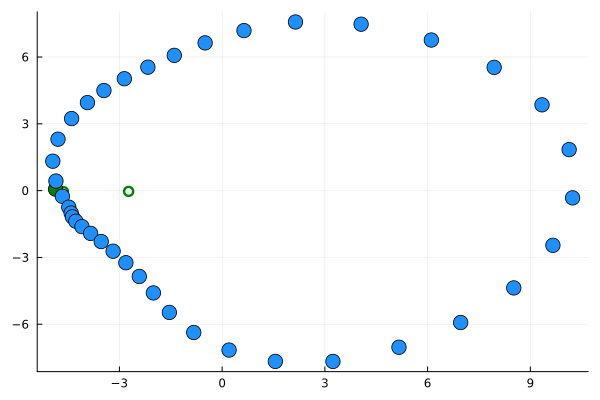

In [26]:
plo=plot()
for i in eachindex(res2[1])
    #println(length(res2[1][i]))
    try
        for j in eachindex(res2[1][i])
           for k = 1:length(res2[1][i][j])
                #for n =1:j
                println(res2[1][i][j])
                if i==39
                    if all(abs.(res2[2][i][j]).<1)
                        scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m=8,color="dodgerblue",markershape=:circle,label=nothing)
                    #else
                    #    scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m = (5, :white, stroke(3, "dodgerblue")),markershape=:circle,label=nothing)
                    end
                elseif i==1    
                    if all(abs.(res2[2][i][j]).<1)
                        scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m=8,color="green",markershape=:circle,label=nothing)
                    else
                        scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m = (5, :white, stroke(3, "green")),markershape=:circle,label=nothing)
                    end
                end
            end
         end
    catch
        continue
    end
end
display(plo)

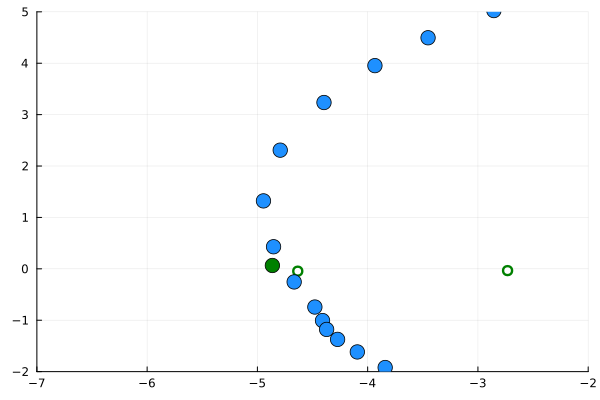

In [29]:
plo_zoom =plo

xlims!(plo_zoom,(-7,-2))
ylims!(plo_zoom,(-2,5))

display(plo_zoom)

In [31]:
abs.(res2[2][1][3]).<1

15-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [151]:
D_pool=[]
plotted_points = []
min_distance = 0.1
det(Diagonal(A))
#for k =1:length(res[1][1])
#D=Diagonal((W_2 *res[1][1][1][1] +h_2) .> 0)
id=1
D=Diagonal(vcat(ones(dims-num_relus),res2[1][1][id][1][end-(num_relus-1):end].>0))
e = (A + W * D) 
F=eigen(e) 
idx_stable=findall(abs.(F.values) .< 1)
idx_unstable=findall(abs.(F.values) .> 1)
#plo=plot(f)
D_pool=[]
println(idx_s)
for i=1:100
    #println(i)
    #try
    for factor=[0.01,0.1]
        z_start = res2[1][1][id][1]
        for idx_s in idx_stable
            z_start += real(F.vectors[:,idx_s]).* (rand() * 2 - 1) * factor#* (3-norm(real(F.vectors[:,idx_s])[begin:3]))#*max(abs.(F.values[idx_s]),0.1) #perturbe into slow eigendiretions more 
        end
        #try
        traj_,D_pool = get_latent_time_series_backwards(50, Matrix(Diagonal(A)), W, h, 2, num_relus; z_0= BigFloat.(z_start),D_pool)
        traj=mapreduce(permutedims,vcat,traj_)            #println(size(traj))
    #only plot points where now value exceeds 7
        filtered_traj = Float64.(traj[vec(all(abs.(traj) .<= 1000, dims=2)), :])
    #println(size(filtered_traj))
    #println(filtered_traj[:,1])
        for j in 1:size(filtered_traj, 1)
            point = filtered_traj[j, :]
            if all(euclidean_distance(point, plotted_point) > min_distance for plotted_point in plotted_points)
                push!(plotted_points, point)
                #scatter!(plo, [point[1]], [point[2]], [point[3]], color = "black", marker = (3))
                scatter!(plo,[predict(M,point)[1]], [predict(M,point)[2]], color = "black", marker = (3),label=nothing)
            end
        end         #catch
            #    continue
        #end
    end
end



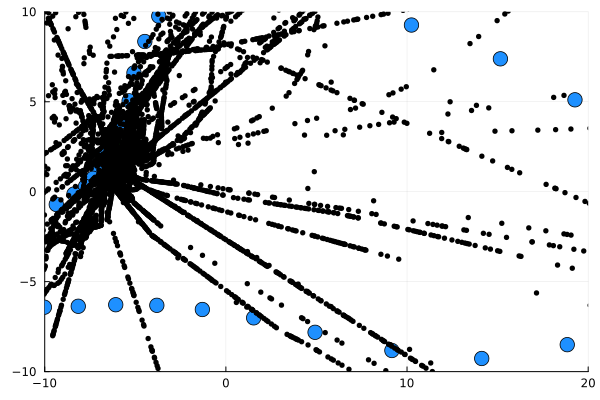

In [152]:
xlims!(plo,(-10,20))
ylims!(plo,(-10,10))
display(plo)

## Plot w/o PCA

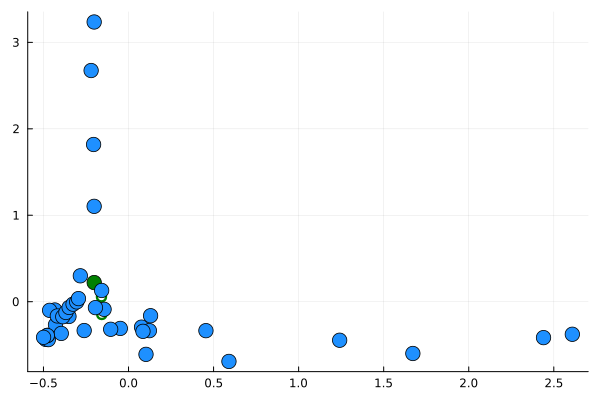

In [526]:
plo=plot()
for i in eachindex(res2[1])
    #println(length(res2[1][i]))
    try
        for j in eachindex(res2[1][i])
           for k = 1:length(res2[1][i][j])
                #for n =1:j
                println(res2[1][i][j])
                if i==39
                    if all(abs.(res2[2][i][j]).<1)
                        scatter!(plo,[res2[1][i][j][k][1]], [res2[1][i][j][k][2]],m=8,color="dodgerblue",markershape=:circle,label=nothing)
                    #else
                    #    scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m = (5, :white, stroke(3, "dodgerblue")),markershape=:circle,label=nothing)
                    end
                elseif i==1    
                    if all(abs.(res2[2][i][j]).<1)
                        scatter!(plo,[res2[1][i][j][k][1]], [res2[1][i][j][k][2]],m=8,color="green",markershape=:circle,label=nothing)
                    else
                        scatter!(plo,[res2[1][i][j][k][1]], [res2[1][i][j][k][2]],m = (5, :white, stroke(3, "green")),markershape=:circle,label=nothing)
                    end
                else 
                    scatter!(plo,[res2[1][i][j][k][1]], [res2[1][i][j][k][2]],m=8,color="red",markershape=:circle,label=nothing)
                end
            end
         end
    catch
        continue
    end
end
display(plo)

In [364]:
plotted_points = []

Any[]

In [365]:
D_pool=[]
Random.seed!(42)

min_distance = 0.001
det(Diagonal(A))
#for k =1:length(res[1][1])
#D=Diagonal((W_2 *res[1][1][1][1] +h_2) .> 0)
id=2
D=Diagonal(vcat(ones(dims-num_relus),res2[1][1][id][1][end-(num_relus-1):end].>0))
e = (A + W * D) 
F=eigen(e) 
idx_stable=findall(abs.(F.values) .< 1)
idx_unstable=findall(abs.(F.values) .> 1)
#plo=plot(f)

D_pool=[]

for i=1:100
    #println(i)
    #try
    for factor=[0.001]
        z_start = res2[1][1][id][1]
        for idx_s in idx_stable
            z_start += real(F.vectors[:,idx_s]).* (rand() * 2 - 1) * factor#* (3-norm(real(F.vectors[:,idx_s])[begin:3]))#*max(abs.(F.values[idx_s]),0.1) #perturbe into slow eigendiretions more 
        end
        traj_,D_pool = get_latent_time_series_backwards(5, Matrix(Diagonal(A)), W, h, 2, num_relus; z_0= BigFloat.(z_start),D_pool)
        traj=mapreduce(permutedims,vcat,traj_)            #println(size(traj))
    #only plot points where now value exceeds 7
        filtered_traj = Float64.(traj[vec(all(abs.(traj) .<= 1000, dims=2)), :])
    #println(size(filtered_traj))
    #println(filtered_traj[:,1])
        for j in 1:size(filtered_traj, 1)
            point = filtered_traj[j, :]
            if all(euclidean_distance(point, plotted_point) > min_distance for plotted_point in plotted_points)
                push!(plotted_points, point)
                #scatter!(plo, [point[1]], [point[2]], [point[3]], color = "black", marker = (3))
                scatter!(plo,[point[1]], [point[2]], color = "black", marker = (3),label=nothing)
            end
        end         #catch
            #    continue
        #end
    end
end



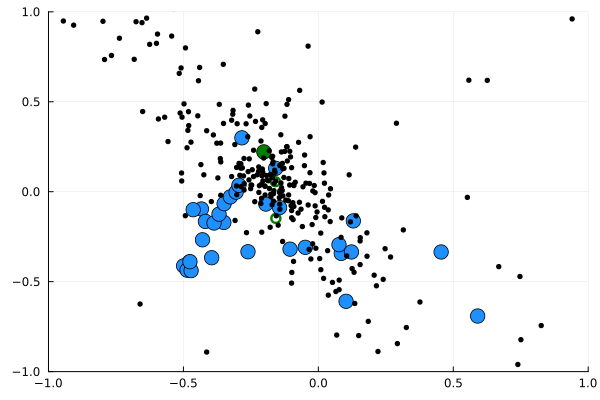

In [18]:
xlims!(plo,(-1,1))
ylims!(plo,(-1,1))
display(plo)

## use Isomap visualization

In [527]:
plotted_points = []

Any[]

In [778]:
plotted_points = []
D_pool=[]
Random.seed!(42)

min_distance = 0.1
det(Diagonal(A))
#for k =1:length(res[1][1])
#D=Diagonal((W_2 *res[1][1][1][1] +h_2) .> 0)
id=3
D=Diagonal(vcat(ones(dims-num_relus),res2[1][1][id][1][end-(num_relus-1):end].>0))
e = (A + W * D) 
F=eigen(e) 
idx_stable=findall(abs.(F.values) .< 1)
idx_unstable=findall(abs.(F.values) .> 1)
#plo=plot(f)

D_pool=[]

for i=1:100
    #println(i)
    #try
    for factor=[0.001]
        z_start = res2[1][1][id][1]
        for idx_s in idx_stable
            z_start += real(F.vectors[:,idx_s]).* (rand() * 2 - 1) * factor#* (3-norm(real(F.vectors[:,idx_s])[begin:3]))#*max(abs.(F.values[idx_s]),0.1) #perturbe into slow eigendiretions more 
        end
        traj_,D_pool = get_latent_time_series_backwards(10, Matrix(Diagonal(A)), W, h, 2, num_relus; z_0= BigFloat.(z_start),D_pool)
        traj=mapreduce(permutedims,vcat,traj_)            #println(size(traj))
    #only plot points where now value exceeds 7
        filtered_traj = Float64.(traj[vec(all(abs.(traj) .<= 1000, dims=2)), :])
    #println(size(filtered_traj))
    #println(filtered_traj[:,1])
        for j in 1:size(filtered_traj, 1)
            point = filtered_traj[j, :]
            if all(euclidean_distance(point, plotted_point) > min_distance for plotted_point in plotted_points)
                push!(plotted_points, point)
                #scatter!(plo, [point[1]], [point[2]], [point[3]], color = "black", marker = (3))
                scatter!(plo,[point[1]], [point[2]], color = "black", marker = (3),label=nothing)
            end
        end         #catch
            #    continue
        #end
    end
end


#points = Vector[]
for i in eachindex(res2[1])
    #println(length(res2[1][i]))
    try
        for j in eachindex(res2[1][i])
           for k = 1:length(res2[1][i][j])
                #for n =1:j
                println(res2[1][i][j])
                push!(plotted_points,Float64.(res2[1][i][j][k]))
                #end
            end
         end
    catch
        continue
    end
end
#M = fit(PCA, transpose(mapreduce(permutedims, vcat, points)); maxoutdim=2)

In [779]:
plotted_points

524-element Vector{Any}:
 [-0.15900913074187187, 0.055349112973438544, -0.09824555042515185, 0.0008731416915100022, 0.2599439681541113, -0.1351361068788683, -0.23275187738144887, -0.38458238206675127, -0.005617371841475037, -0.09750615175411244, 0.0018861964390907114, -0.687197543732392, -0.3053366968146029, 0.5012840633150992, 0.5674761964598932]
 [-0.1340114755782573, -0.01336130564120917, -0.11185680213590778, -0.021919314071111584, 0.2913722902457672, -0.11916245954436552, -0.23719927213780773, -0.3296610036677292, -0.027693474447558607, -0.05980742577639761, 0.0026477166609849417, -0.7437163130356287, -0.37491790469977965, 0.4958627352837894, 0.559814655193337]
 [-0.11679559816529833, -0.15576544456387373, -0.15549633723030173, -0.06789031128924364, 0.3650559304615492, -0.08271672000781312, -0.23101137717505607, -0.22093709041290088, -0.05363762982677404, 0.010462854012139082, 0.008184102953799042, -0.8686610165398687, -0.4947602862370104, 0.49173930187377823, 0.5423556826063667]


In [780]:
M2 = fit(Isomap, hcat(plotted_points...),k=8)
R = predict(M2) 

2×524 Matrix{Float64}:
 -2.55989    -2.55874   -2.60721   -3.39893  …  3.93693   3.21703   2.80607
 -0.0196729  -0.162787  -0.398873  -1.23939     0.347868  0.306995  0.239287

In [781]:
predict(M2,Float64.(res2[1][1][2][1]))

2×1 Matrix{Float64}:
 -2.710730251830522
  0.44279714594695785

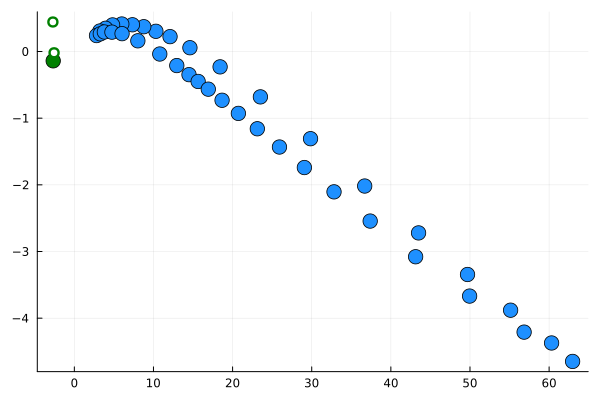

In [789]:
plo=plot()
for i in eachindex(res2[1])
    #println(length(res2[1][i]))
    try
        for j in eachindex(res2[1][i])
           for k = 1:length(res2[1][i][j])
                #for n =1:j
                println(res2[1][i][j])
                if i==39
                    if all(abs.(res2[2][i][j]).<1)
                        scatter!(plo,[predict(M2,Float64.(res2[1][i][j][k]))[1]], [predict(M2,Float64.(res2[1][i][j][k]))[2]],m=8,color="dodgerblue",markershape=:circle,label=nothing)
                    #else
                    #    scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m = (5, :white, stroke(3, "dodgerblue")),markershape=:circle,label=nothing)
                    end
                elseif i==1    
                    if all(abs.(res2[2][i][j]).<1)
                        scatter!(plo,[predict(M2,Float64.(res2[1][i][j][k]))[1]], [predict(M2,Float64.(res2[1][i][j][k]))[2]],m=8,color="green",markershape=:circle,label=nothing)
                    else
                        println("unstable",j)
                        scatter!(plo,[predict(M2,Float64.(res2[1][i][j][k]))[1]], [predict(M2,Float64.(res2[1][i][j][k]))[2]],m = (5, :white, stroke(3, "green")),markershape=:circle,label=nothing)
                    end
                end
            end
         end
    catch
        continue
    end
end
display(plo)

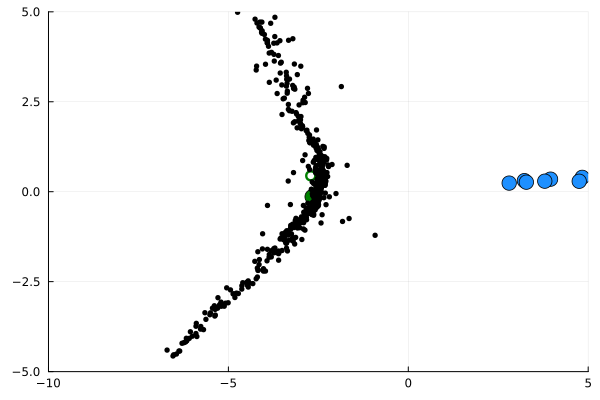

In [791]:

xlims!(plo,(-10,5))
ylims!(plo,(-5,5))
display(plo)

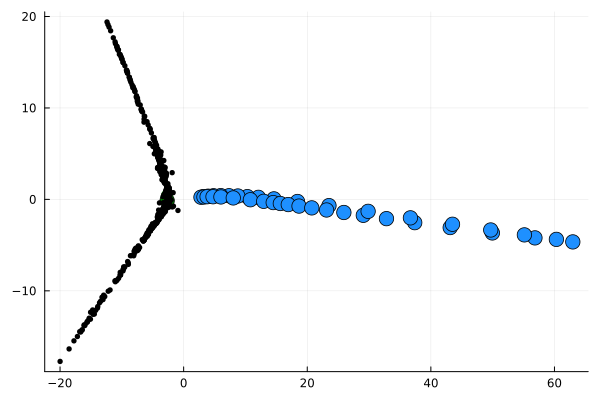

In [790]:
D_pool=[]
plotted_points=[]
min_distance = 0.001
det(Diagonal(A))
#for k =1:length(res[1][1])
#D=Diagonal((W_2 *res[1][1][1][1] +h_2) .> 0)
id=3
D=Diagonal(vcat(ones(dims-num_relus),res2[1][1][id][1][end-(num_relus-1):end].>0))
e = (A + W * D) 
F=eigen(e) 
idx_stable=findall(abs.(F.values) .< 1)
idx_unstable=findall(abs.(F.values) .> 1)
#plo=plot(f)

D_pool=[]

for i=1:200
    #println(i)
    #try
    for factor=[0.0005]
        z_start = res2[1][1][id][1]
        for idx_s in idx_stable
            z_start += real(F.vectors[:,idx_s]).* (rand() * 2 - 1) * factor#* (3-norm(real(F.vectors[:,idx_s])[begin:3]))#*max(abs.(F.values[idx_s]),0.1) #perturbe into slow eigendiretions more 
        end
            #try
        traj_,D_pool = get_latent_time_series_backwards(10, Matrix(Diagonal(A)), W, h, 2, num_relus; z_0= BigFloat.(z_start),D_pool)
        traj=mapreduce(permutedims,vcat,traj_)            #println(size(traj))
    #only plot points where now value exceeds 7
        filtered_traj = Float64.(traj[vec(all(abs.(traj) .<= 1000, dims=2)), :])
    #println(size(filtered_traj))
    #println(filtered_traj[:,1])
        for j in 1:size(filtered_traj, 1)
            point = filtered_traj[j, :]
            if all(euclidean_distance(point, plotted_point) > min_distance for plotted_point in plotted_points)
                push!(plotted_points, point)
                #scatter!(plo, [point[1]], [point[2]], [point[3]], color = "black", marker = (3))
                scatter!(plo,[predict(M2,point)[1]], [predict(M2,point)[2]], color = "black", marker = (3),label=nothing)
            end
        end         #catch
            #    continue
        #end
    end
end
display(plo)


In [771]:
abs.(res2[2][1][1])

15-element Vector{Float32}:
 0.7035077
 0.7035077
 0.4034208
 0.4034208
 0.31953374
 0.39642784
 0.6363363
 0.6363363
 0.44299895
 0.5924174
 0.7735019
 0.8924505
 0.8924505
 0.93947214
 0.93947214

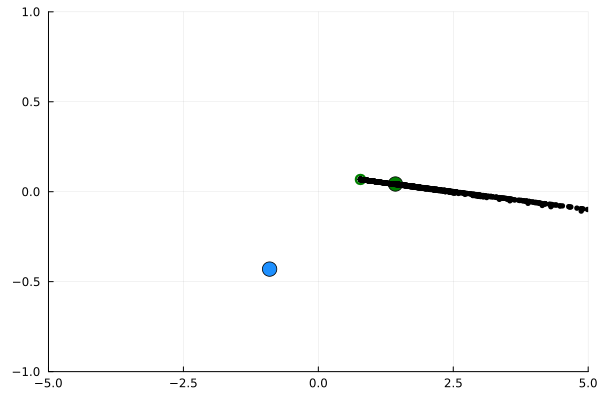

In [373]:
#ylims!(plo,(-5,15))
#xlims!(plo,(-15,-3))
ylims!(plo,(-1,1))
xlims!(plo,(-5,5))
display(plo)


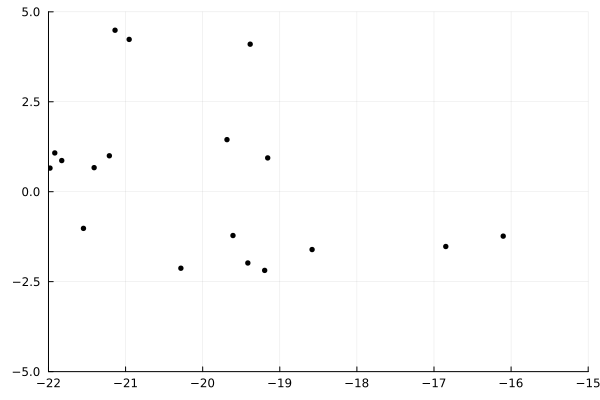

In [148]:
ylims!(plo,(-5,5))
xlims!(plo,(-22,-15))
#ylims!(plo,(-5,0))
#xlims!(plo,(-5,-3))
display(plo)


In [577]:
abs.(res2[2][1][1])

15-element Vector{Float32}:
 0.7035077
 0.7035077
 0.4034208
 0.4034208
 0.31953374
 0.39642784
 0.6363363
 0.6363363
 0.44299895
 0.5924174
 0.7735019
 0.8924505
 0.8924505
 0.93947214
 0.93947214

In [295]:
res2[1]

39-element Vector{Array}:
 Array[Array[Float32[-0.15908985, 0.0556464, -0.09813191, 0.00075609516, 0.25980568, -0.13518295, -0.23279218, -0.38465962, -0.0055553117, -0.097768724, 0.0019202338, -0.68687624, -0.30460292, 0.5012249, 0.5675605]], Array[Float32[-0.15737201, -0.14830919, 0.085505, -0.01361327, 0.1652656, -0.021136321, -0.048202842, -0.3535783, -0.17671005, -0.33032236, 0.011657724, 0.13348505, -0.24436446, 0.34732622, 0.5936724]], Array[Float32[-0.20173742, 0.2212763, -0.18696737, -0.036460675, 0.36662295, -0.18166083, -0.44154918, -0.5081214, 0.095310315, 0.12835763, -0.6735798, -1.362425, -0.46198386, 0.52704036, 0.46472192]]]
 Array[]
 Array[]
 Array[]
 Array[]
 Array[]
 Array[]
 Array[]
 Array[]
 Array[]
 ⋮
 Array[]
 Array[]
 Array[]
 Array[]
 Array[]
 Array[]
 Array[]
 Array[]
 Array[Array[Float32[2.4395745, -0.41552848, -0.22761254, 2.3603415, -0.52391785, -0.22074537, 2.096567, 2.1599188, 2.4418335, -0.13122049, -0.045737833, -0.1852173, 3.6375484, 2.0127718, 2.823041